/tmp/ipykernel_321/3518464841.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_321/3518464841.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_321/3518464841.py:41: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_321/3518464841.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


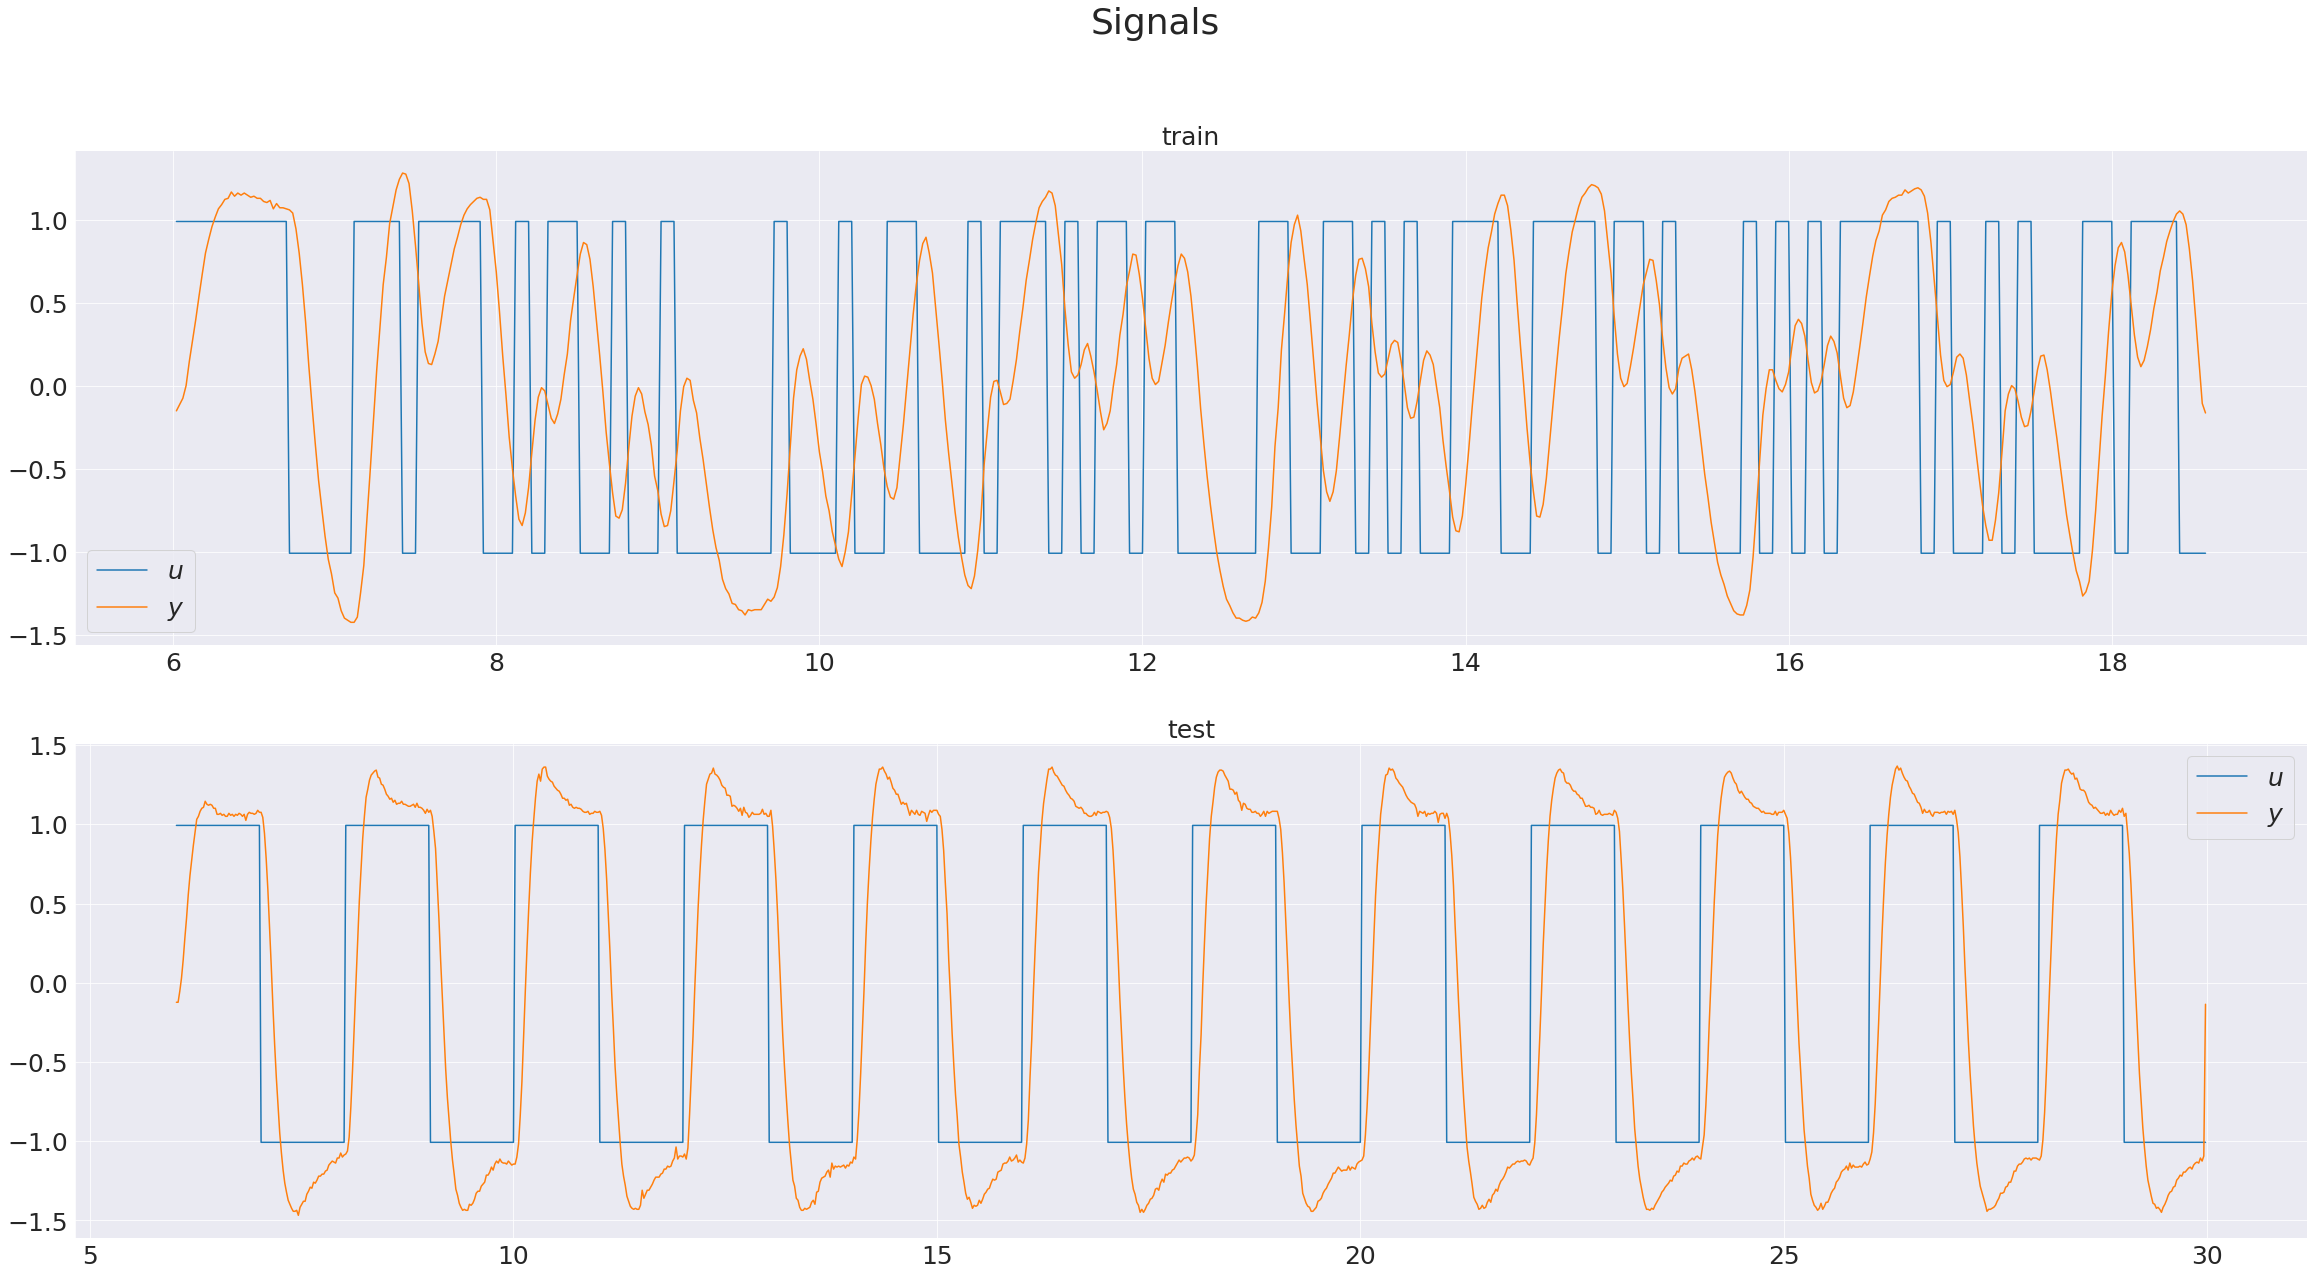

In [47]:
import copy

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from scipy.signal import impulse, lti, step, butter, lfilter, welch
from control import TransferFunction, bode
np.set_printoptions(linewidth=np.inf)

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = np.roll((df1['y']-joint_avg_y)/joint_std_y,-1) # MRTVI CAS := -1
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = np.roll((df2['y']-joint_avg_y)/joint_std_y,-1)

u_train = np.asarray(df2['u']).reshape(-1, 1)
u_valid = np.asarray(df1['u']).reshape(-1, 1)
y_train = np.asarray(df2['y']).reshape(-1,1)
y_valid = np.asarray(df1['y']).reshape(-1,1)

fig, axn = plt.subplots(2,1,figsize=(40,20))
title = 'Signals'
fig.suptitle(title)
axn[0].plot(df2['time'], u_train, label=r'$u$')
axn[0].plot(df2['time'], y_train, label=r'$y$')
axn[0].set_title('train')
axn[0].legend()
axn[1].plot(df1['time'], u_valid, label=r'$u$')
axn[1].plot(df1['time'], y_valid, label=r'$y$')
axn[1].set_title('test')
axn[1].legend()
#plt.savefig('figs/{}.eps'.format(title))
plt.show()


# Basic implementation of ARX model
### (the FROLS model presents itselpf as an ARMAX model, i.e., it accepts a variable for number of lags in the error term, but once the regressors are fitted it shows as if only the regressors of lagged y an u - does not realy use lagged e)

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


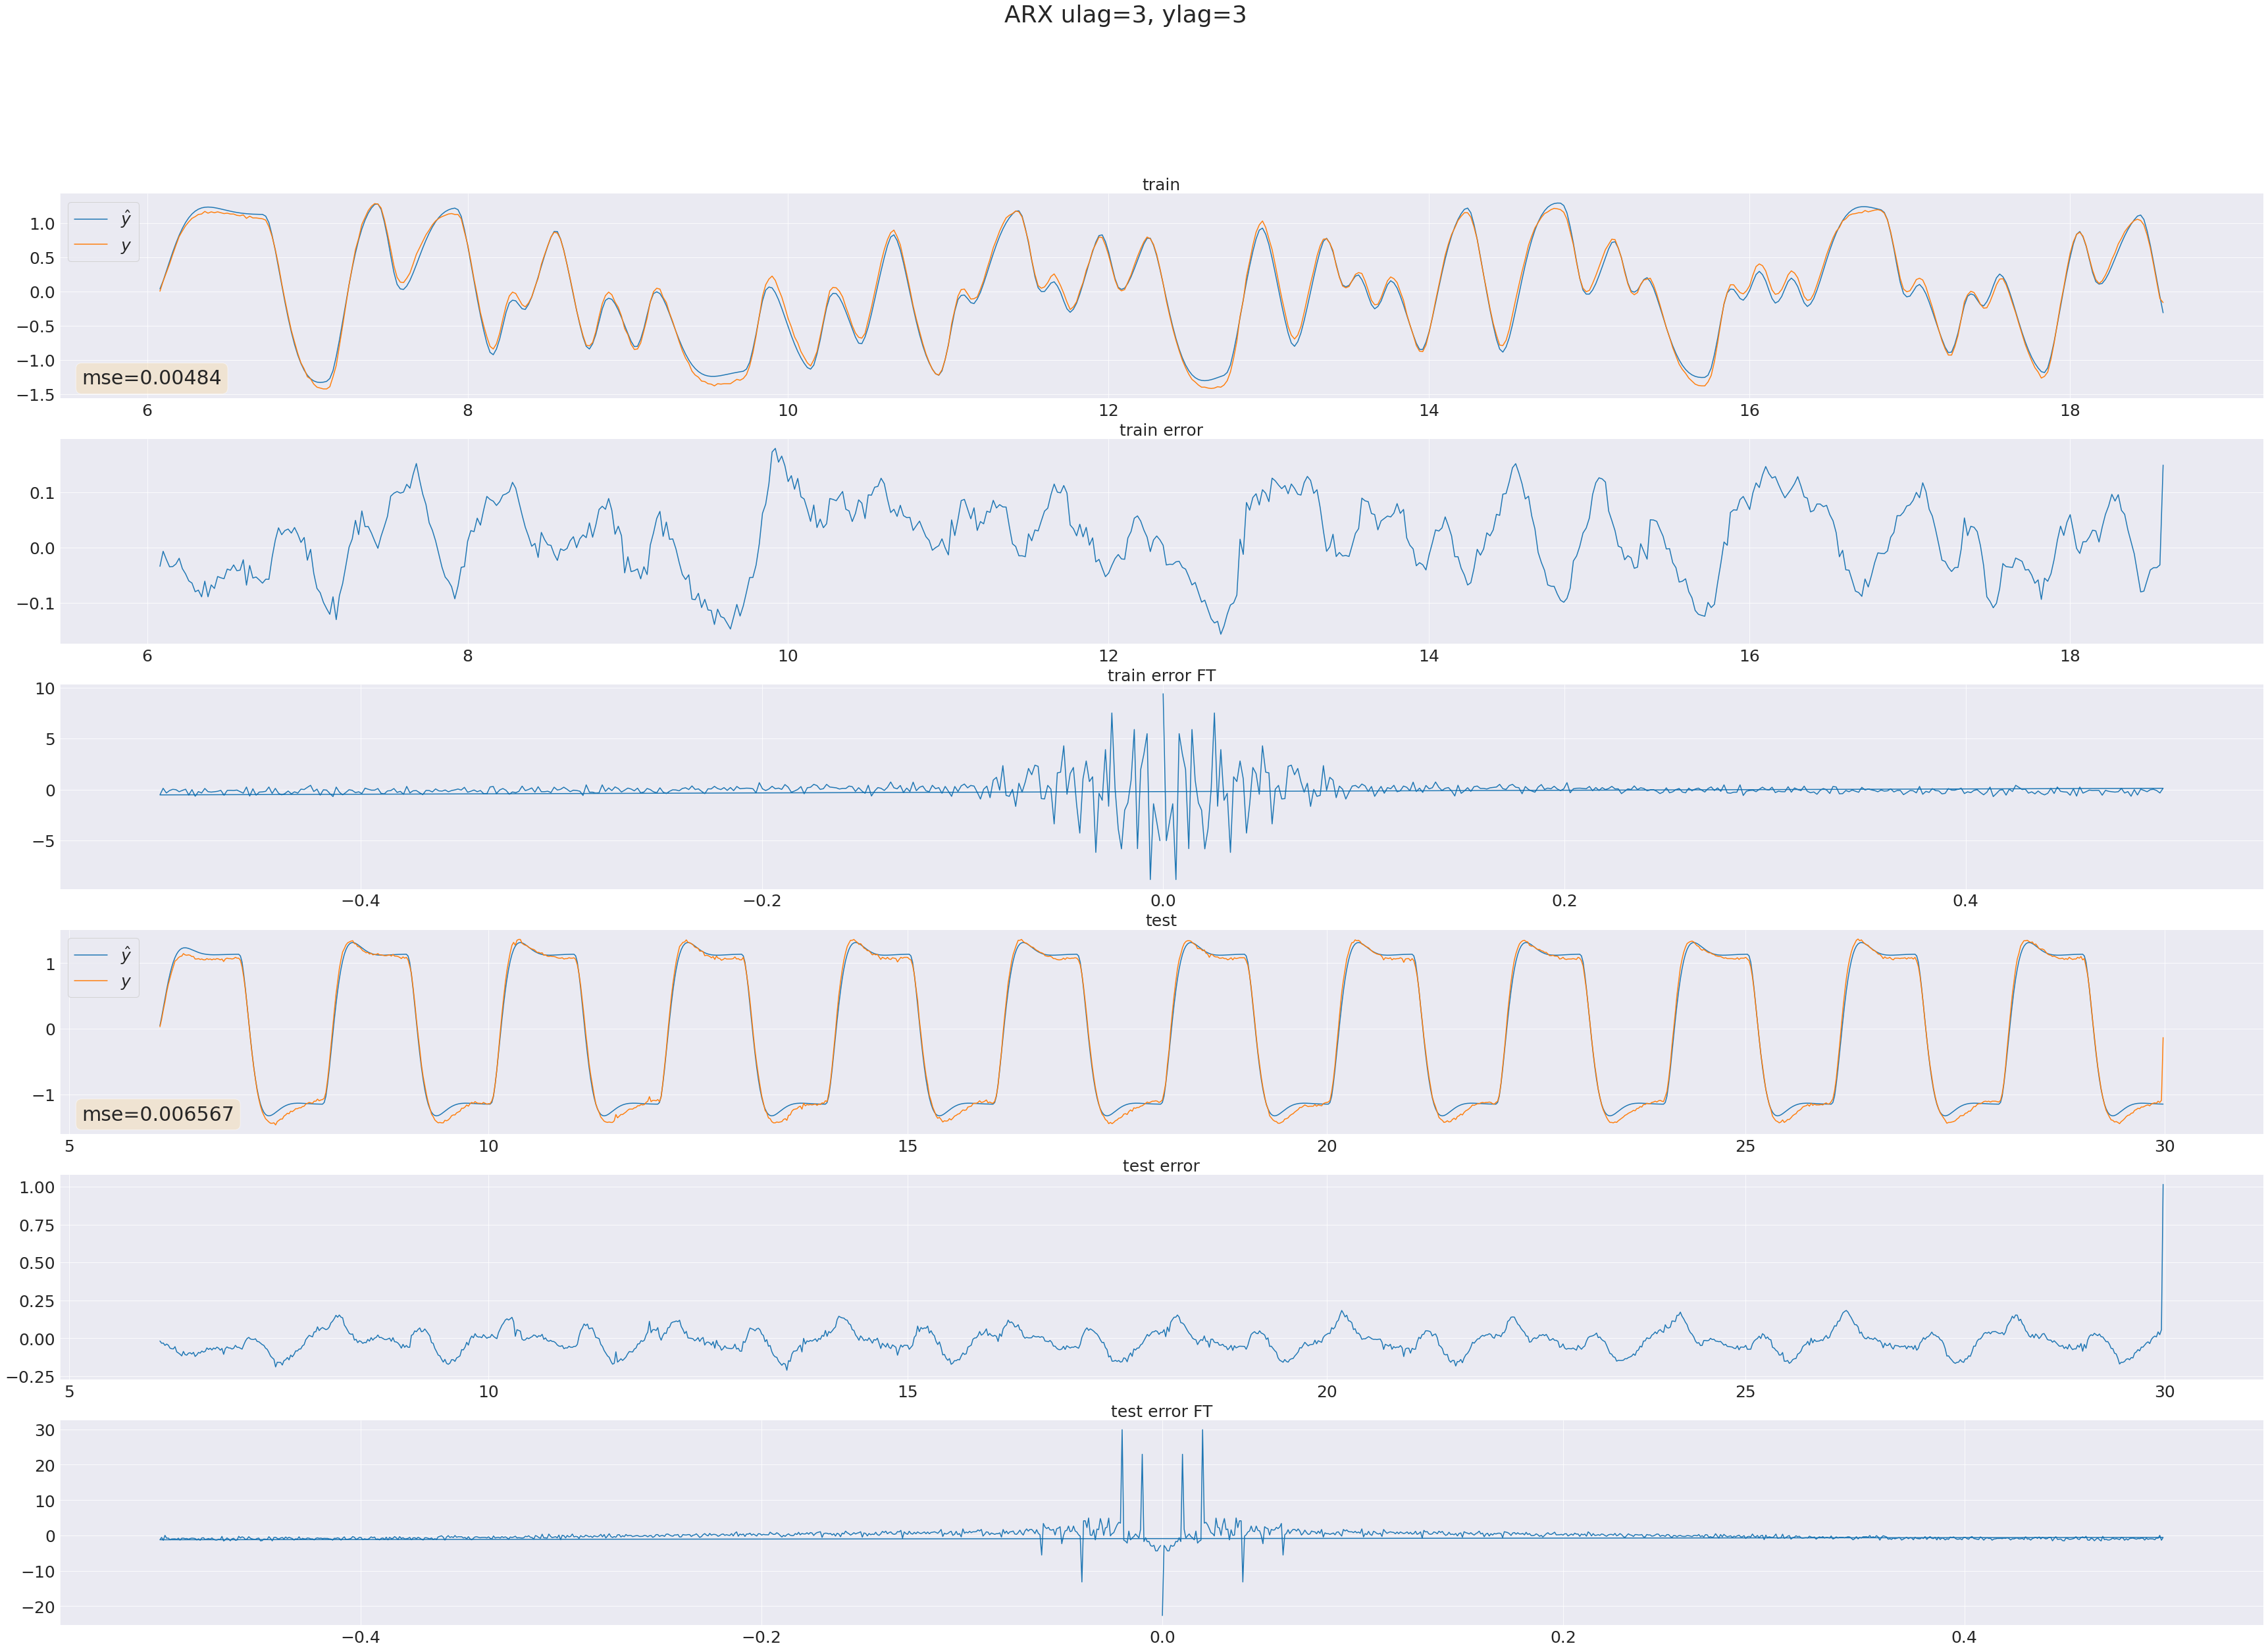

  Regressors   Parameters             ERR
0     y(k-1)   1.1580E+00  9.66115706E-01
1     y(k-2)   1.7742E-01  2.96087257E-02
2    x1(k-2)   3.2666E-02  2.74910492E-03
3    x1(k-3)   3.5561E-02  1.95589398E-04
4     y(k-3)  -4.0652E-01  3.51761086E-04
5    x1(k-1)   1.3008E-02  1.08092663E-04


In [48]:
ylag = 3
ulag = 3
lag = max(ulag,ylag)

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    n_terms=ylag+ulag,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=u_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(6,1,figsize=(60,40))
title = 'ARX ulag={}, ylag={}'.format(ulag, ylag)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df2['time'][lag:], y_train[lag:] - yhat_train)
axn[1].set_title('train error')
axn[2].plot(np.fft.fftfreq(len(yhat_train), 1), np.fft.fft((y_train[lag:] - yhat_train).reshape(-1)))
axn[2].set_title('train error FT')
axn[3].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[3].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[3].set_title('test')
axn[3].legend(loc=2)
axn[3].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[3].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[4].plot(df1['time'][lag:], y_valid[lag:] - yhat_valid)
axn[4].set_title('test error')
axn[5].plot(np.fft.fftfreq(len(yhat_valid), 1), np.fft.fft((y_valid[lag:] - yhat_valid).reshape(-1)))
axn[5].set_title('test error FT')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
axn[3].grid(True)
axn[4].grid(True)
axn[5].grid(True)
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

# Residual analysis: $R_{\epsilon}$ and $R_{\epsilon u}$ [On train set]
### Here the idea is to check, firstly, if the residuals are distributed as white noise, and secondly, if the residuals are independent of input u. For the second case, if not true, then the information content of u is not maximally implemented in the model, i.e., the model is not optimal.

Ljung-Box test:
        lb_stat  lb_pvalue
10  2263.152414        0.0
-------------
Significant correlations at lags: [625]
Pearson correlation: -0.058457454291422996, p-value: 0.14403428797388151
Spearman correlation: -0.0548908097183933, p-value: 0.17017024092063437
Mutual information: 0.6930655198532911


/home/kreljo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


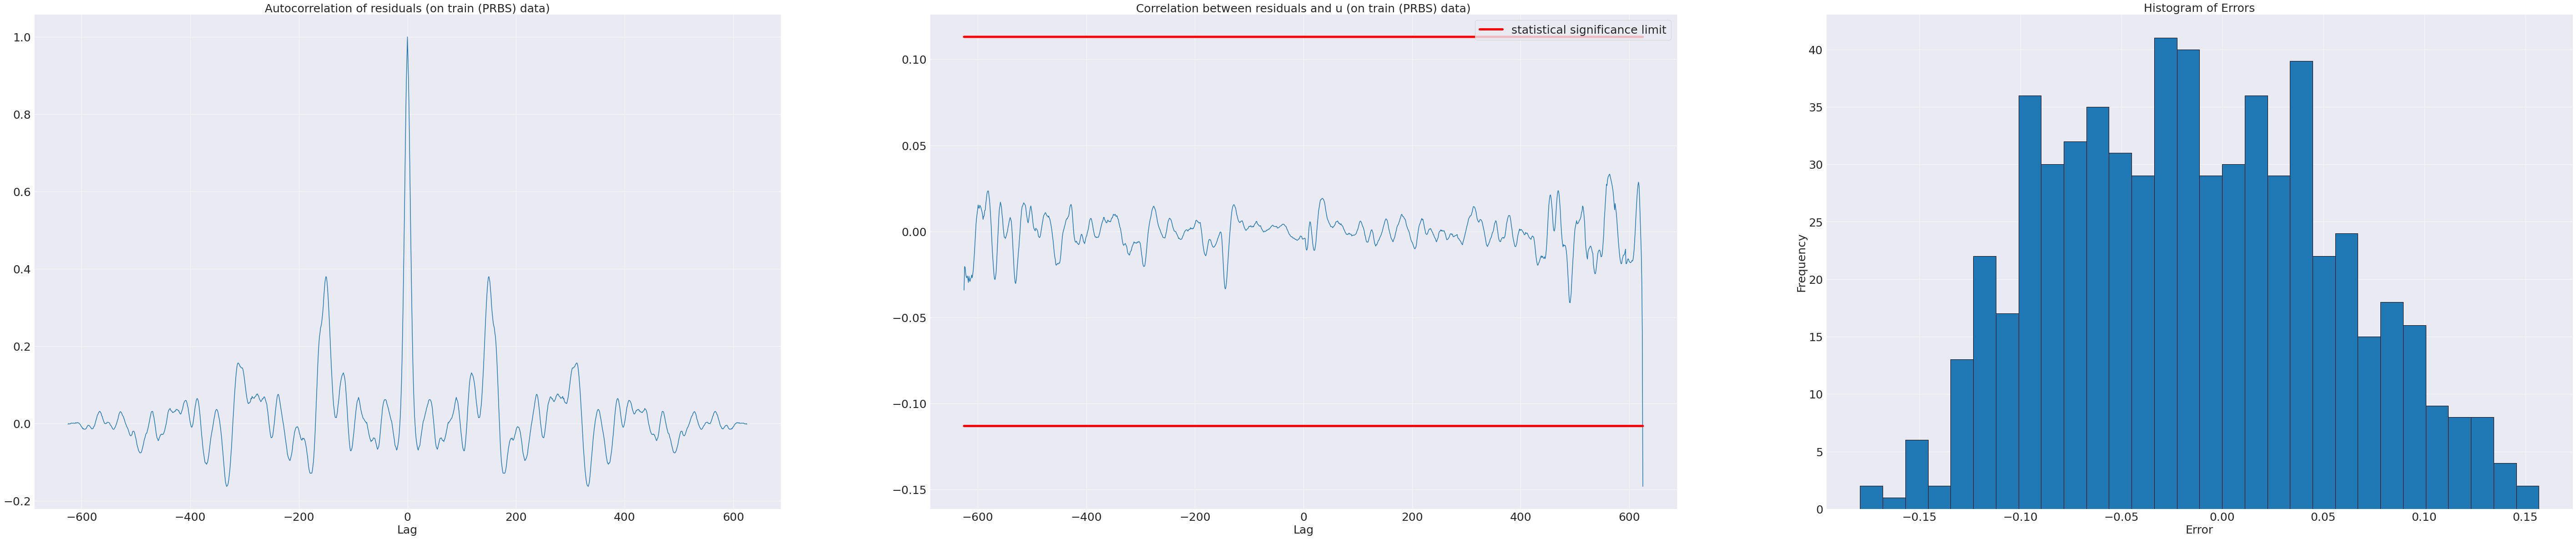

In [49]:
e_train = (yhat_train - y_train[lag:]).reshape(-1)
l = len(e_train)
lags = np.arange(-l + 1, l)


#------- white noise test (Ljung, pg. 512) ------------------

# R_epsilon
# R_e = []
# for i in range(l):
#     R_e.append(np.sum(1 / (l - i) * e_train[:l - i] * e_train[i:]))
R_e = sc.signal.correlate(e_train, e_train, mode='full')

# calculate the number of overlapping points at each lag
overlap_e = np.correlate(np.ones_like(e_train), np.ones_like(e_train), mode='full')

R_e = R_e # / overlap_e to normalize

# perform the Ljung-Box test
ljung_box = sm.stats.diagnostic.acorr_ljungbox(e_train, lags=[10], return_df=True)
print('Ljung-Box test:')
print(ljung_box)
print('-------------')

fig, axn = plt.subplots(1,3,figsize=(100,20))
axn[0].plot(lags,R_e/max(R_e))
axn[0].set_title('Autocorrelation of residuals (on train (PRBS) data)')
axn[0].set_xlabel('Lag')
axn[0].grid(True)

#------- u, e independence test --------------

# R_epsilon,u
R_eu = scipy.signal.correlate(e_train, u_train[lag:, 0], mode='full')

# calculate the number of overlapping points at each lag
overlap_eu = np.correlate(np.ones_like(e_train), np.ones_like(u_train[lag:, 0]), mode='full')

R_eu = R_eu / overlap_eu # to normalize

# remove lag zero
zero_lag_index = np.where(lags == 0)[0][0]
R_eu = np.delete(R_eu, zero_lag_index)
lags = np.delete(lags, zero_lag_index)

# Check the statistical significance of the correlations
# If all correlations are zero, then `a` and `b` are statistically independent
stat_sig = 2 / np.sqrt(l/2)
significant_correlations = np.where(np.abs(R_eu) > stat_sig)
print("Significant correlations at lags:", lags[significant_correlations])

# pearson
corr, p_value = sc.stats.pearsonr(e_train, u_train[lag:, 0])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

# spearman
corr, p_value = scipy.stats.spearmanr(e_train, u_train[lag:, 0])
print(f'Spearman correlation: {corr}, p-value: {p_value}')

# mutal information
mi = mutual_info_score(e_train, u_train[lag:, 0])
print(f'Mutual information: {mi}')

axn[1].plot(lags,R_eu)
axn[1].plot(lags, [stat_sig for i in range(len(lags))], lw=5, c='r', label='statistical significance limit')
axn[1].plot(lags, [-stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].set_title('Correlation between residuals and u (on train (PRBS) data)')
axn[1].set_xlabel('Lag')
axn[1].legend(loc=1)
axn[1].grid(True)

# Plot the histogram
axn[2].hist(e_train, bins=30, edgecolor='k')
axn[2].set_title('Histogram of Errors')
axn[2].set_xlabel('Error')
axn[2].set_ylabel('Frequency')
axn[2].grid(True)
plt.show()

### The results show that the residuals cannot be described as an instance of white noise process. However, the correlation between e and u shows, that the residuals do not depend largely on the lagged inputs of u, both for positive and negative lags (the pearson correlation p-value is greater than 0.05 (if smaller, there would be some statistical correlation between both time series). It should be noted that the greater values at the end of the e-u cross-correlation function are due to the fact that the statistical averaging for greater lags is much smaller dou to a small numer of samples. Also, the correlated signal is below the threshold of statistical significance (denoted with red lines). The distribution of errors is close to symmetric - except for the spike at the value of ~ -0.03.

### We can trade off some of the model accuracy for model simplicity by introducing an information criteria such as Akaike Information Criteria (AIC) (can be chosen as an argument of FROLS), e.g. keeping 6 of the regeressors:

/home/kreljo/anaconda3/lib/python3.9/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/kreljo/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


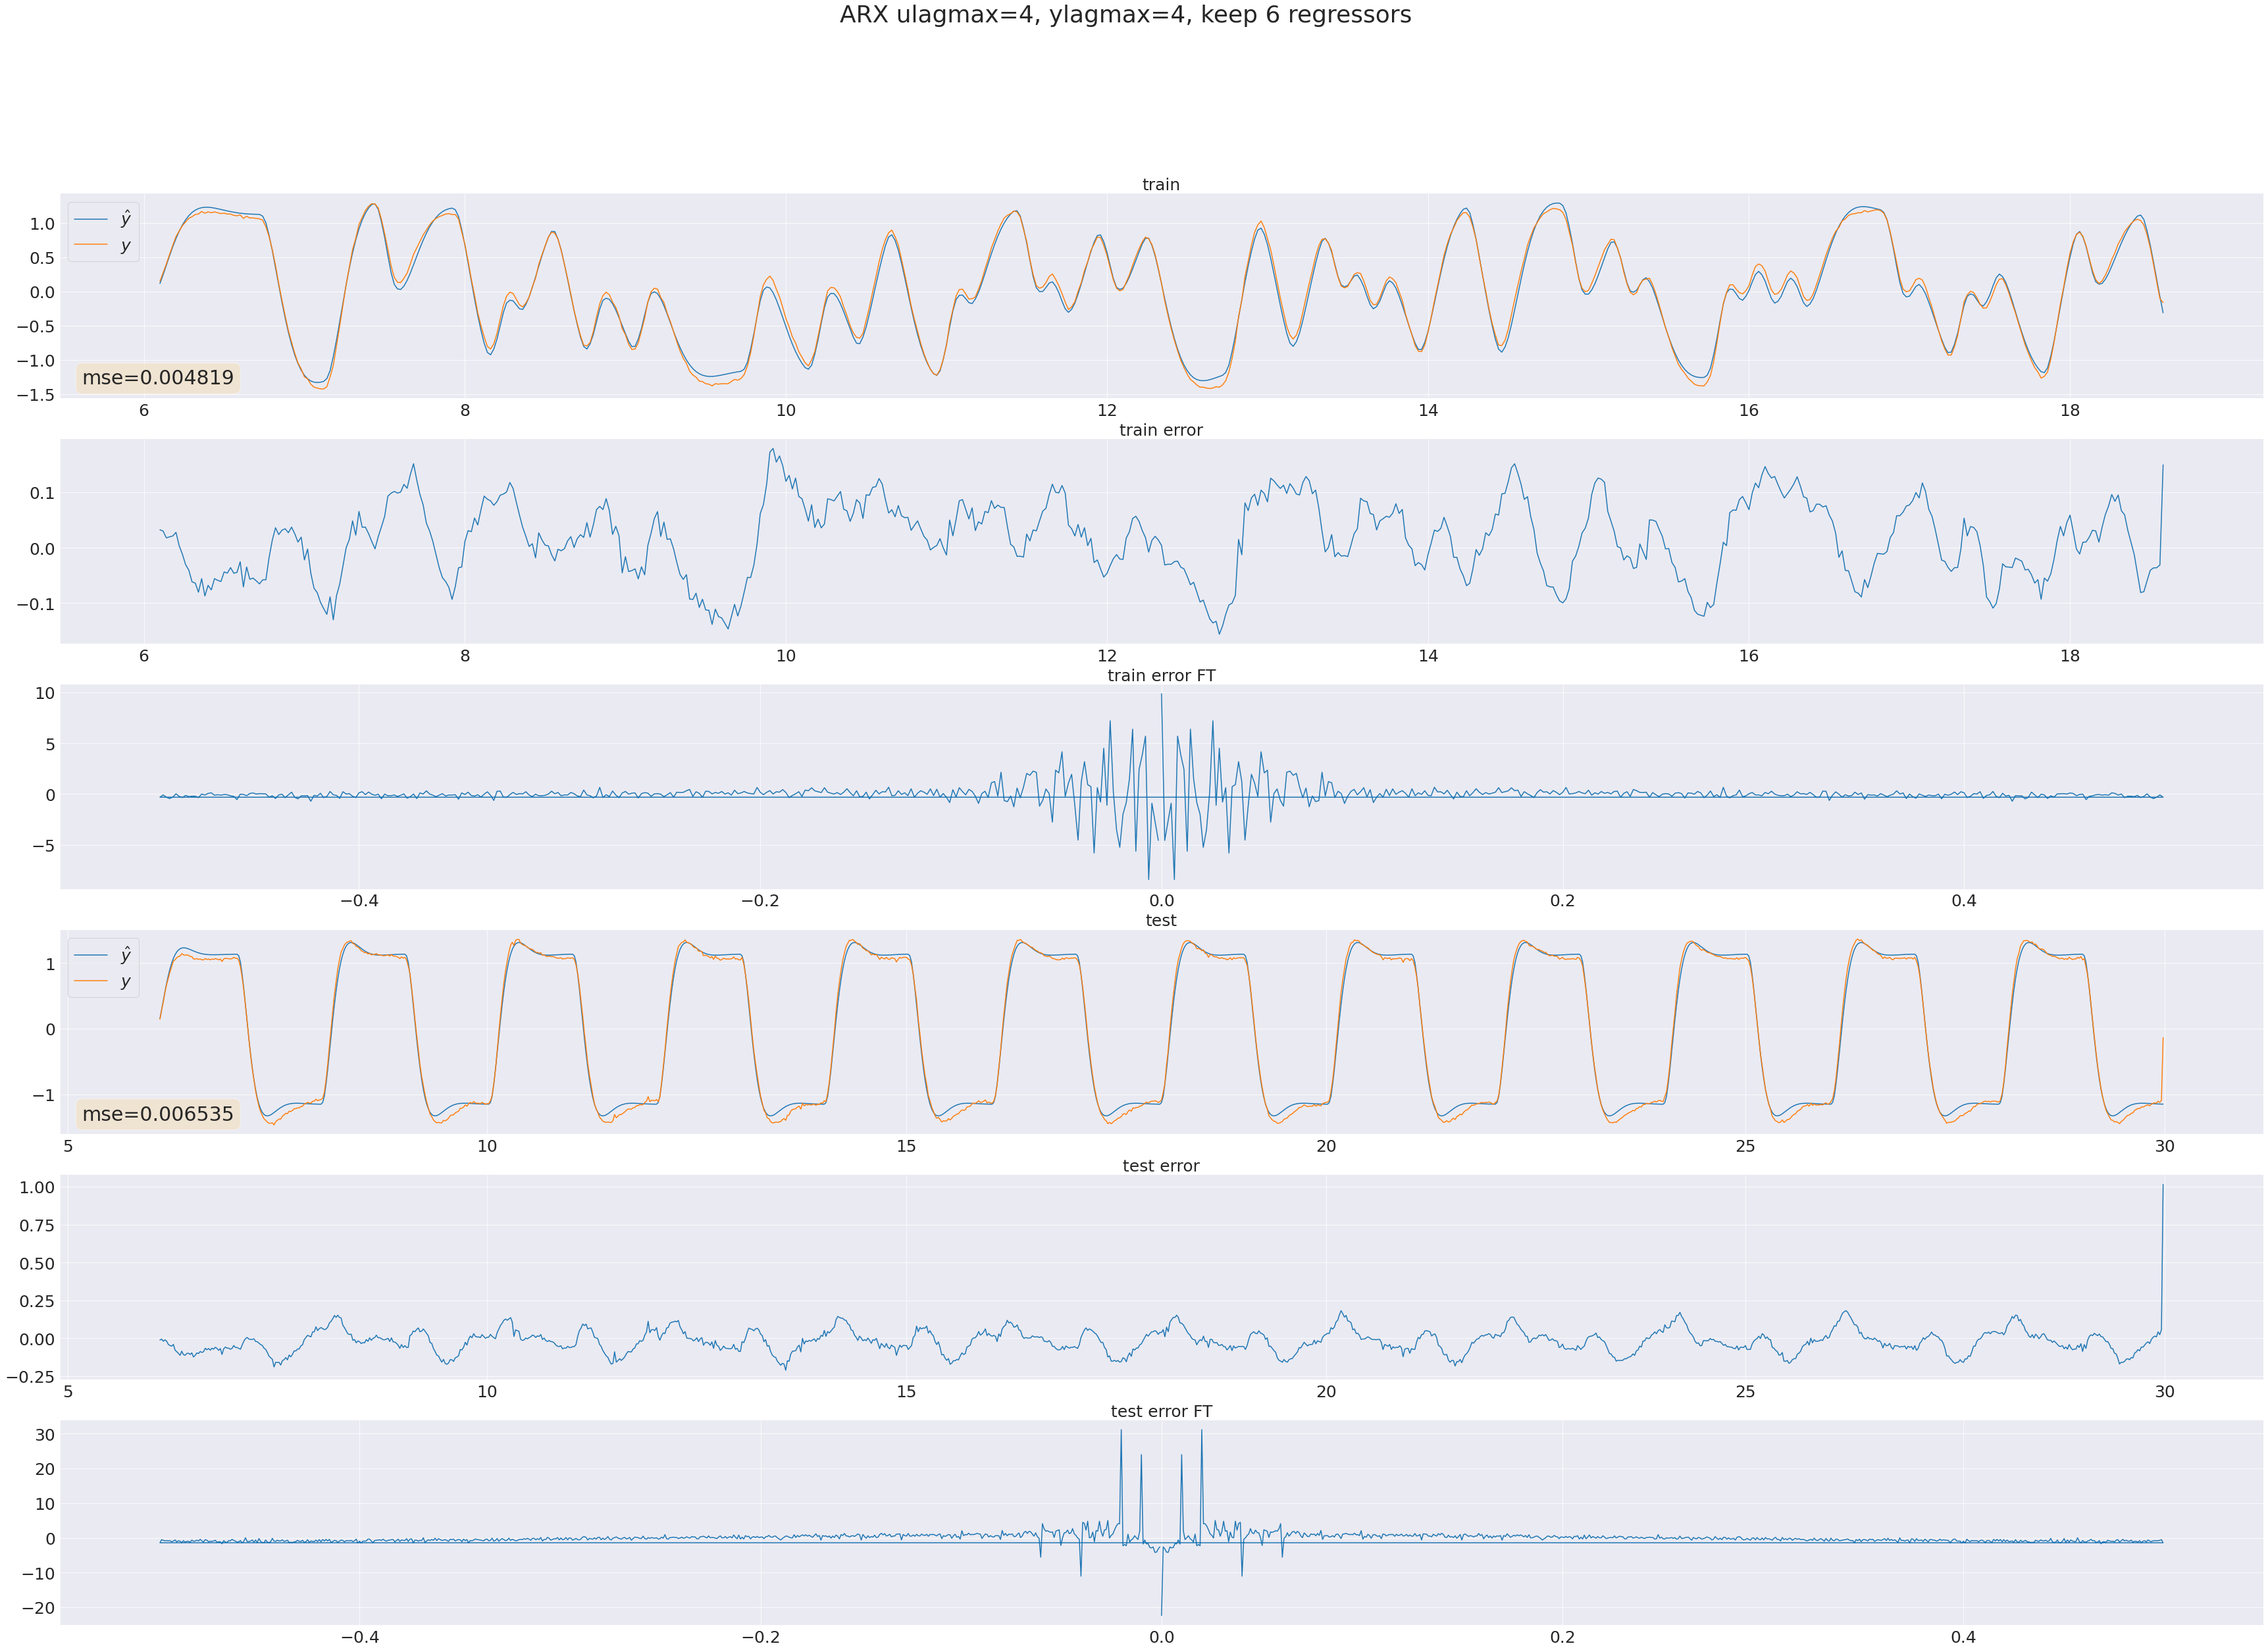

  Regressors   Parameters             ERR
0     y(k-1)   1.1547E+00  9.66132056E-01
1     y(k-2)   1.8301E-01  2.95966209E-02
2    x1(k-2)   3.2717E-02  2.74488911E-03
3    x1(k-3)   3.5734E-02  1.95941518E-04
4     y(k-3)  -4.0894E-01  3.54429244E-04
5    x1(k-1)   1.3028E-02  1.08418476E-04


In [50]:
ylag = 4
ulag = 4
elag = 4
lag = max(ulag,ylag,elag)
keep_n_regressors = 6

model = FROLS(
    ylag=ylag,
    xlag=ulag,
    elag=elag,
    order_selection=True,
    info_criteria='aic', # Akaike Information Criterion
    n_info_values=keep_n_regressors,
    estimator='least_squares',
    extended_least_squares=False,
    basis_function=Polynomial(degree=1) # linear
)
model.fit(X=u_train, y=y_train)

yhat_train = model._n_step_ahead_prediction(X=u_train, y=y_train[:lag], steps_ahead=len(y_train) - lag)
yhat_valid = model._n_step_ahead_prediction(X=u_valid, y=y_valid[:lag], steps_ahead=len(y_valid) - lag)

mse_train = mean_squared_error(y_train[lag:], yhat_train)
mse_valid = mean_squared_error(y_valid[lag:], yhat_valid)

fig, axn = plt.subplots(6,1,figsize=(60,40))
title = 'ARX ulagmax={}, ylagmax={}, keep {} regressors'.format(ulag, ylag, keep_n_regressors)
fig.suptitle(title)
axn[0].plot(df2['time'][lag:], yhat_train, label=r'$\hat{y}$')
axn[0].plot(df2['time'][lag:], y_train[lag:], label=r'$y$')
axn[0].set_title('train')
axn[0].legend(loc=2)
axn[0].text(0.01, 0.05, 'mse={}'.format(round(mse_train,6)), transform=axn[0].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[1].plot(df2['time'][lag:], y_train[lag:] - yhat_train)
axn[1].set_title('train error')
axn[2].plot(np.fft.fftfreq(len(yhat_train), 1), np.fft.fft((y_train[lag:] - yhat_train).reshape(-1)))
axn[2].set_title('train error FT')
axn[3].plot(df1['time'][lag:], yhat_valid, label=r'$\hat{y}$')
axn[3].plot(df1['time'][lag:], y_valid[lag:], label=r'$y$')
axn[3].set_title('test')
axn[3].legend(loc=2)
axn[3].text(0.01, 0.05, 'mse={}'.format(round(mse_valid,6)), transform=axn[3].transAxes, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axn[4].plot(df1['time'][lag:], y_valid[lag:] - yhat_valid)
axn[4].set_title('test error')
axn[5].plot(np.fft.fftfreq(len(yhat_valid), 1), np.fft.fft((y_valid[lag:] - yhat_valid).reshape(-1)))
axn[5].set_title('test error FT')
axn[0].grid(True)
axn[1].grid(True)
axn[2].grid(True)
axn[3].grid(True)
axn[4].grid(True)
axn[5].grid(True)
#plt.savefig('figs/{}.eps'.format(title))
plt.show()

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)

### can lead to similar performance but less complex and more interpretable model.

Ljung-Box test:
        lb_stat  lb_pvalue
10  2231.504958        0.0
-------------
Significant correlations at lags: [624]
Pearson correlation: -0.06888746153010962, p-value: 0.08529010226728691
Spearman correlation: -0.06731318819387455, p-value: 0.0926913950739379
Mutual information: 0.6930844592486123


/home/kreljo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


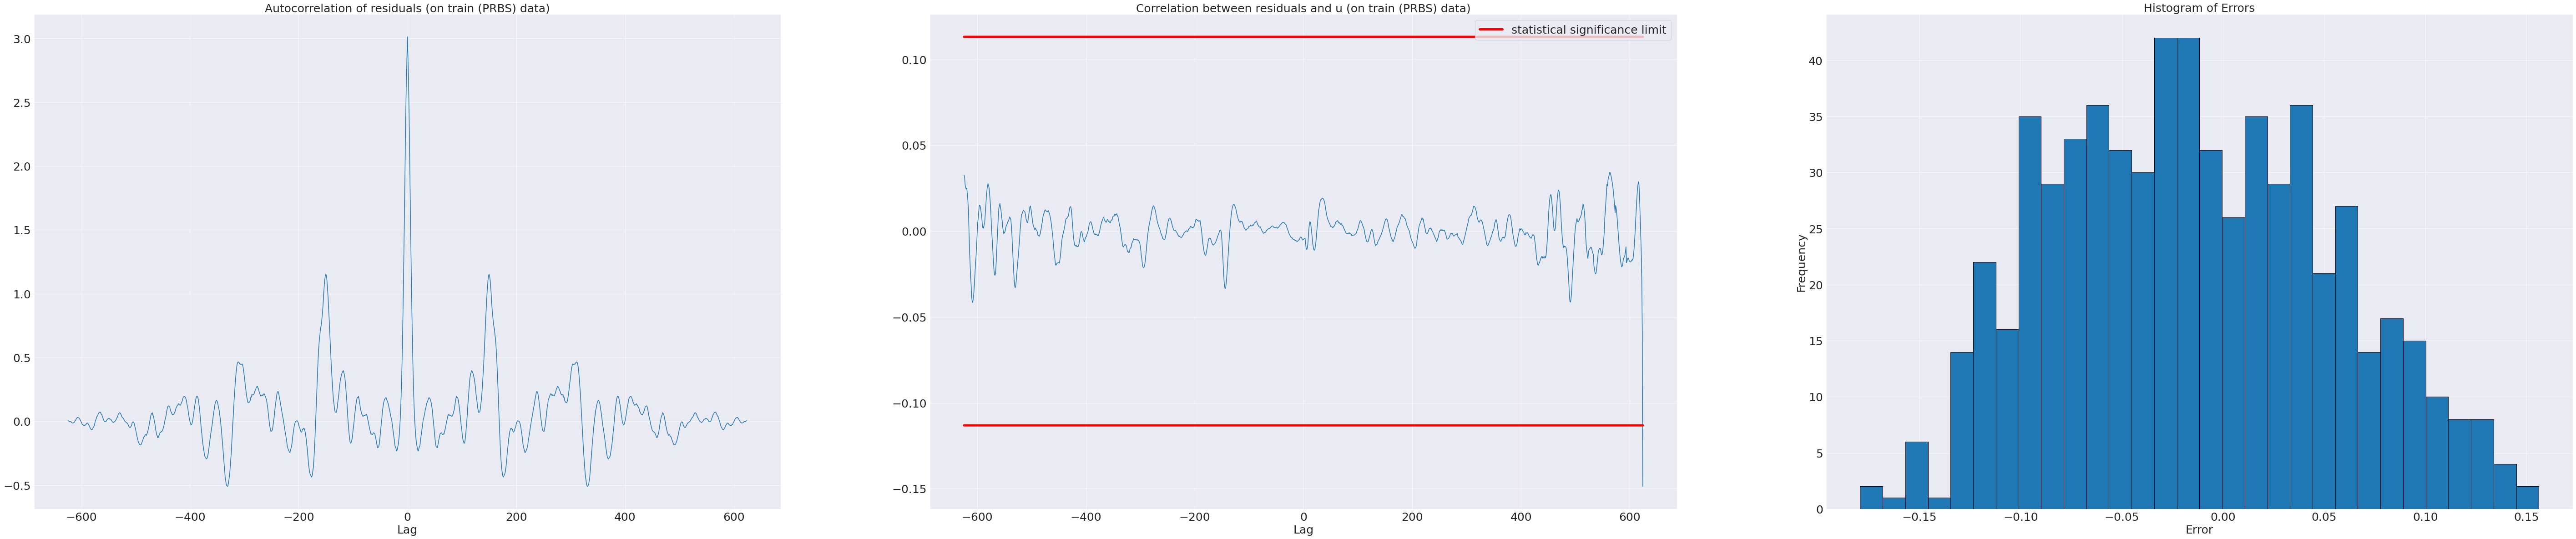

In [51]:
e_train = (yhat_train - y_train[lag:]).reshape(-1)
l = len(e_train)
lags = np.arange(-l + 1, l)

#------- white noise test (Ljung, pg. 512) ------------------

# R_epsilon
# R_e = []
# for i in range(l):
#     R_e.append(np.sum(1 / (l - i) * e_train[:l - i] * e_train[i:]))
R_e = sc.signal.correlate(e_train, e_train, mode='full')

# calculate the number of overlapping points at each lag
overlap_e = np.correlate(np.ones_like(e_train), np.ones_like(e_train), mode='full')

R_e = R_e # / overlap_e to normalize

# perform the Ljung-Box test
ljung_box = sm.stats.diagnostic.acorr_ljungbox(e_train, lags=[10], return_df=True)
print('Ljung-Box test:')
print(ljung_box)
print('-------------')

fig, axn = plt.subplots(1,3,figsize=(100,20))
axn[0].plot(lags,R_e)
axn[0].set_title('Autocorrelation of residuals (on train (PRBS) data)')
axn[0].set_xlabel('Lag')
axn[0].grid(True)

#------- u, e independence test --------------

# R_epsilon,u
R_eu = scipy.signal.correlate(e_train, u_train[lag:, 0], mode='full')

# calculate the number of overlapping points at each lag
overlap_eu = np.correlate(np.ones_like(e_train), np.ones_like(u_train[lag:, 0]), mode='full')

R_eu = R_eu / overlap_eu # to normalize

# remove lag zero
zero_lag_index = np.where(lags == 0)[0][0]
R_eu = np.delete(R_eu, zero_lag_index)
lags = np.delete(lags, zero_lag_index)

# Check the statistical significance of the correlations
# If all correlations are zero, then `a` and `b` are statistically independent
stat_sig = 2 / np.sqrt(l/2)
significant_correlations = np.where(np.abs(R_eu) > stat_sig)
print("Significant correlations at lags:", lags[significant_correlations])

# pearson
corr, p_value = sc.stats.pearsonr(e_train, u_train[lag:, 0])
print(f'Pearson correlation: {corr}, p-value: {p_value}')

# spearman
corr, p_value = scipy.stats.spearmanr(e_train, u_train[lag:, 0])
print(f'Spearman correlation: {corr}, p-value: {p_value}')

# mutal information
mi = mutual_info_score(e_train, u_train[lag:, 0])
print(f'Mutual information: {mi}')

axn[1].plot(lags,R_eu)
axn[1].plot(lags, [stat_sig for i in range(len(lags))], lw=5, c='r', label='statistical significance limit')
axn[1].plot(lags, [-stat_sig for i in range(len(lags))], lw=5, c='r')
axn[1].set_title('Correlation between residuals and u (on train (PRBS) data)')
axn[1].legend(loc=1)
axn[1].set_xlabel('Lag')
axn[1].grid(True)

# Plot the histogram
axn[2].hist(e_train, bins=30, edgecolor='k')
axn[2].set_title('Histogram of Errors')
axn[2].set_xlabel('Error')
axn[2].set_ylabel('Frequency')
axn[2].grid(True)
plt.show()

### We see that when using the Aikake Information Criterium to only keep a certain number of regressors, we achieve better results on the test (and training set). However, the correlation between e and u is greater although still statistically unsignificant. One could also loop through different orders of the model and calculate AIC = n * np.log(mse) + 2 * num_params on each model fit, but in our case the number of combinations (of orders)  is sufficiently low to be checked 'by hand'.
### By letting the algorithm decide which regressors to keep (with respect to AIC) we simultaneously determine the 'delay time (mrtvi cas)', optimal for our model

## Next, we compute the Bode diagram of the surrogate model and compare it to the original

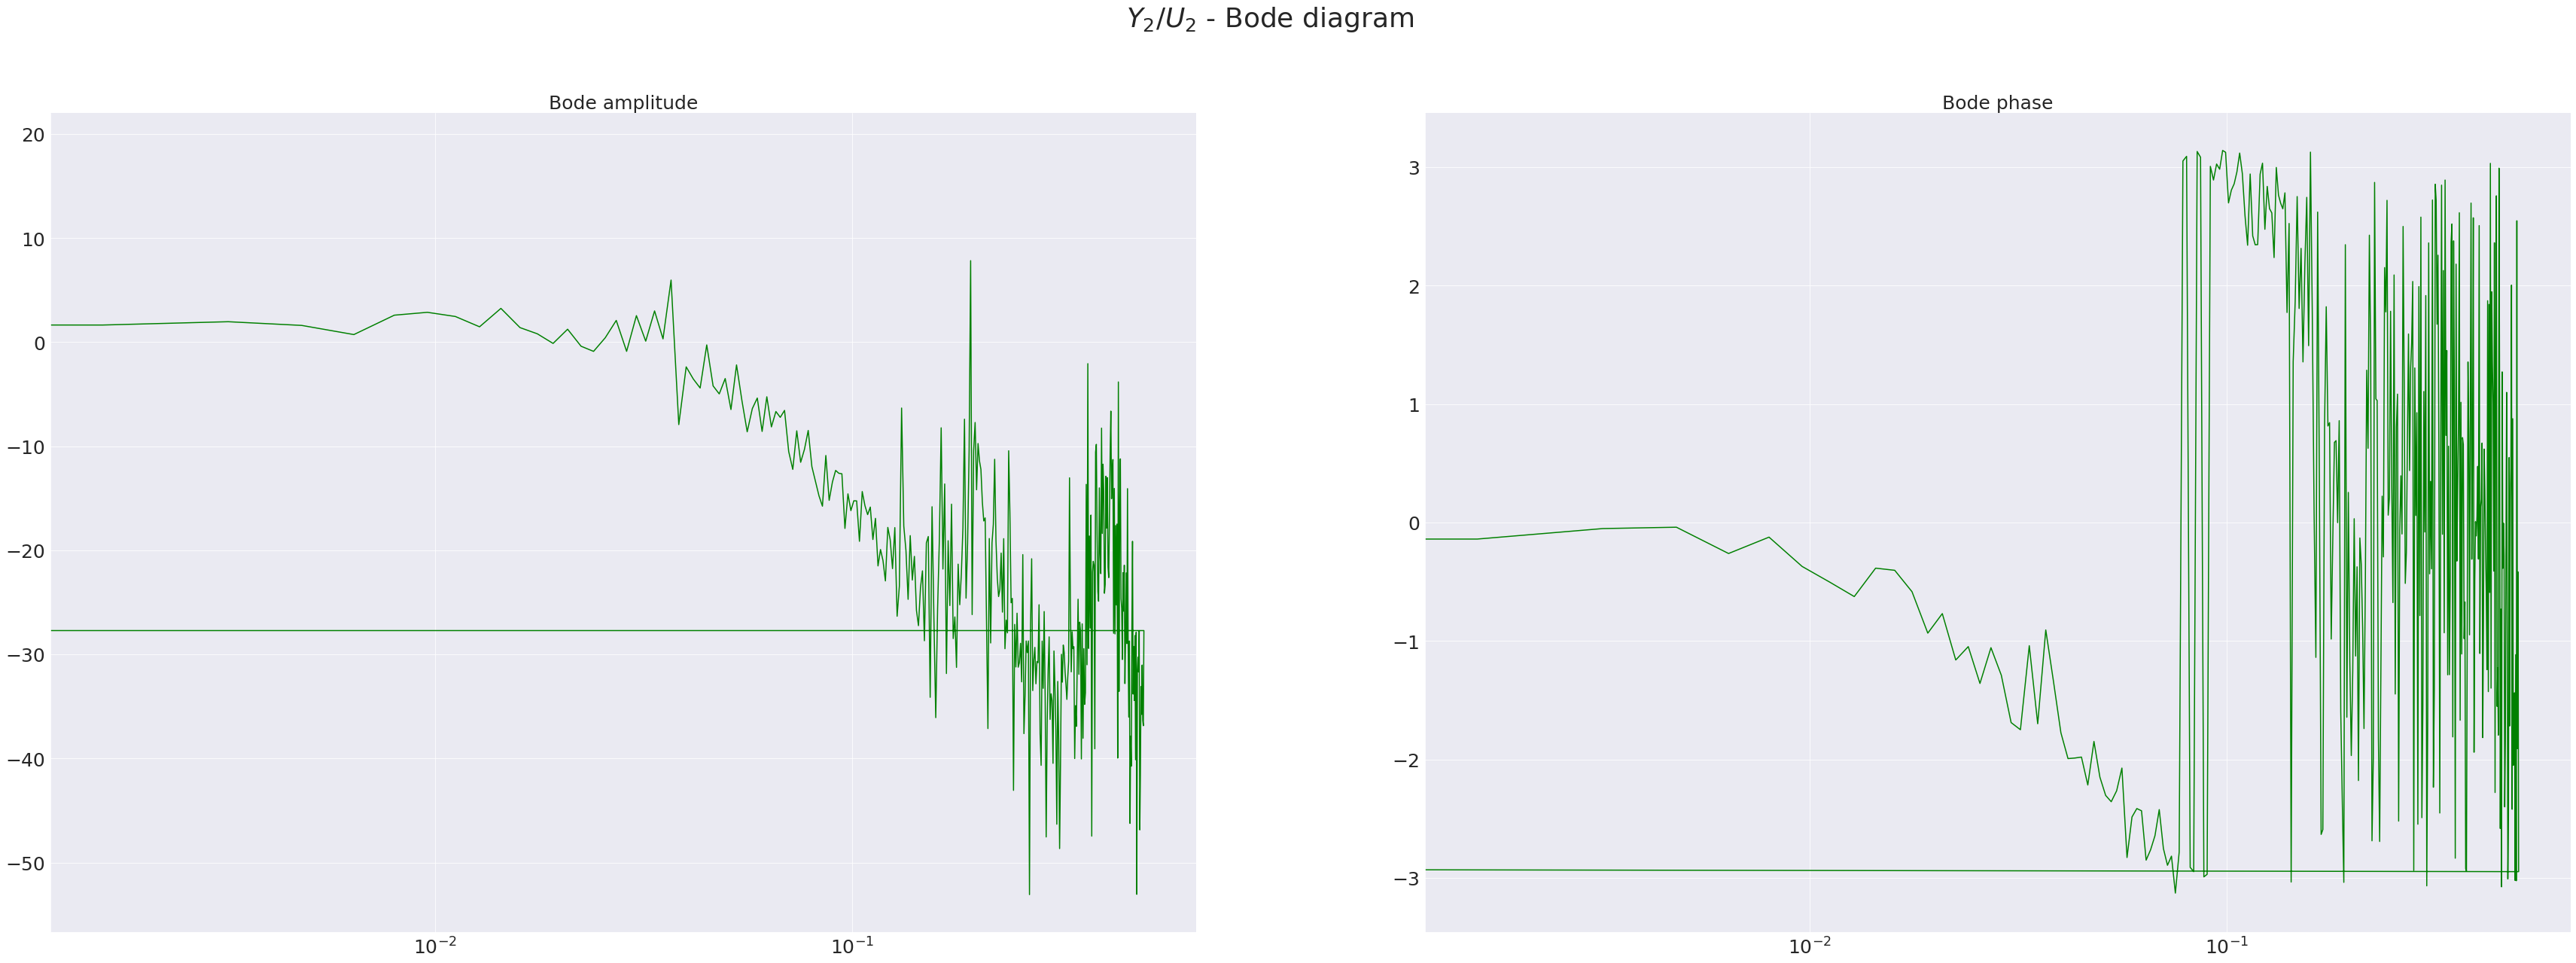

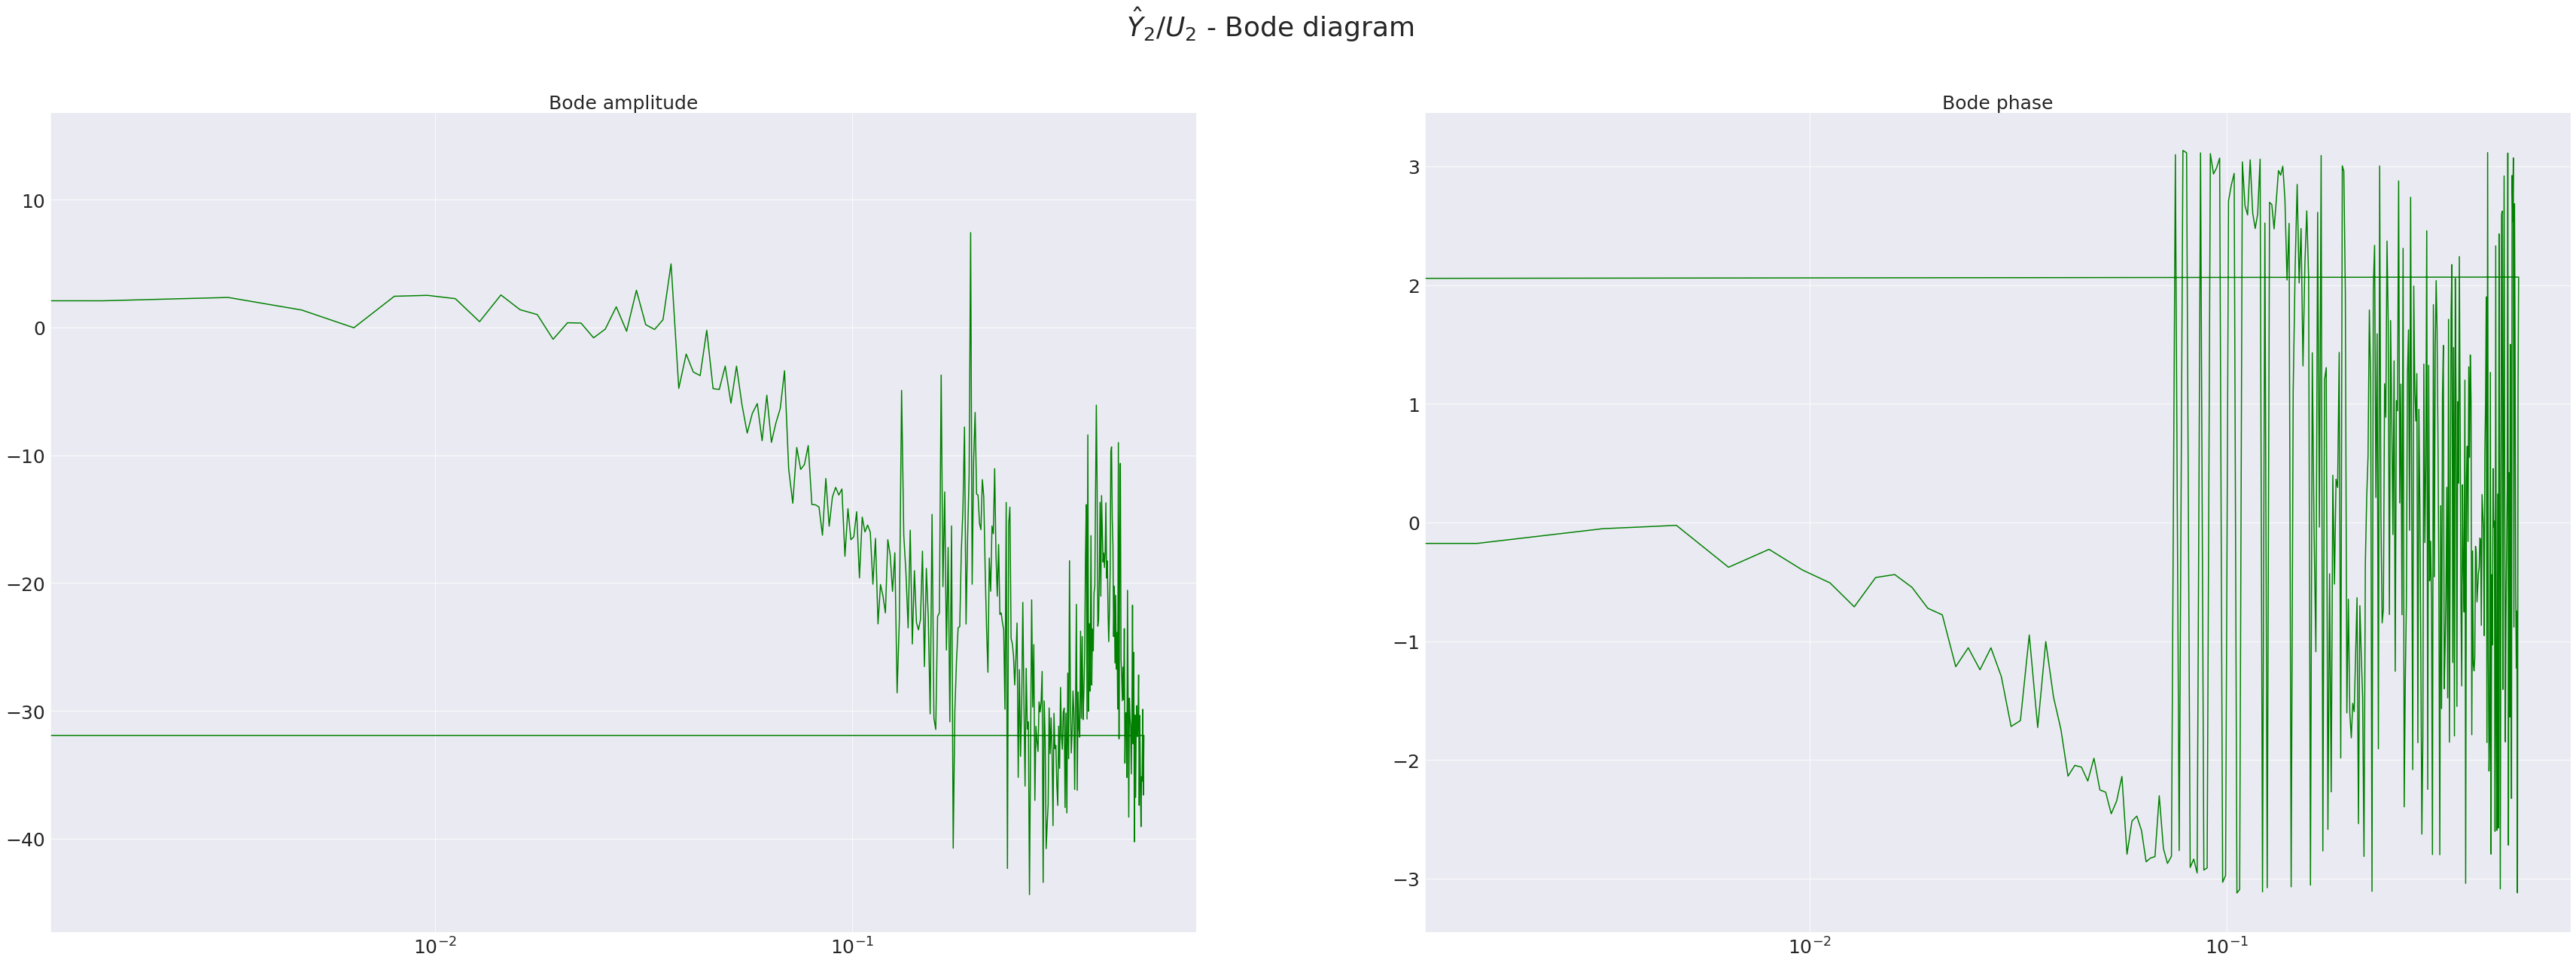

In [52]:
u_train = u_train.reshape(-1)
y_train = y_train.reshape(-1)
yhat_train = yhat_train.reshape(-1)

fs = 1 # define sampling frequency to be 1

freqs = np.fft.fftfreq(len(u_train[lag:]), 1)
ft_u = np.fft.fft(u_train[lag:])
ft_y = np.fft.fft(y_train[lag:])


fig, axn = plt.subplots(1,2,figsize=(60,20))
fig.suptitle(r'$Y_2/U_2$ - Bode diagram')
ft_G = ft_y / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[0].grid(True)
axn[1].grid(True)
plt.show()

freqs = np.fft.fftfreq(len(u_train[lag:]), 1)
ft_u = np.fft.fft(u_train[lag:])
ft_yhat = np.fft.fft(yhat_train)

fig, axn = plt.subplots(1,2,figsize=(60,20))
fig.suptitle(r'$\hat{Y}_2/U_2$ - Bode diagram')
ft_G = ft_yhat / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[0].grid(True)
axn[1].grid(True)
plt.show()

### The linear model seem to mimic the transfer function Bode diagram of the original system quite well. It should be noted, that the Bode diagram, obtained from the full length signal produces a smoother Bode plot as can be seen from the plot below:

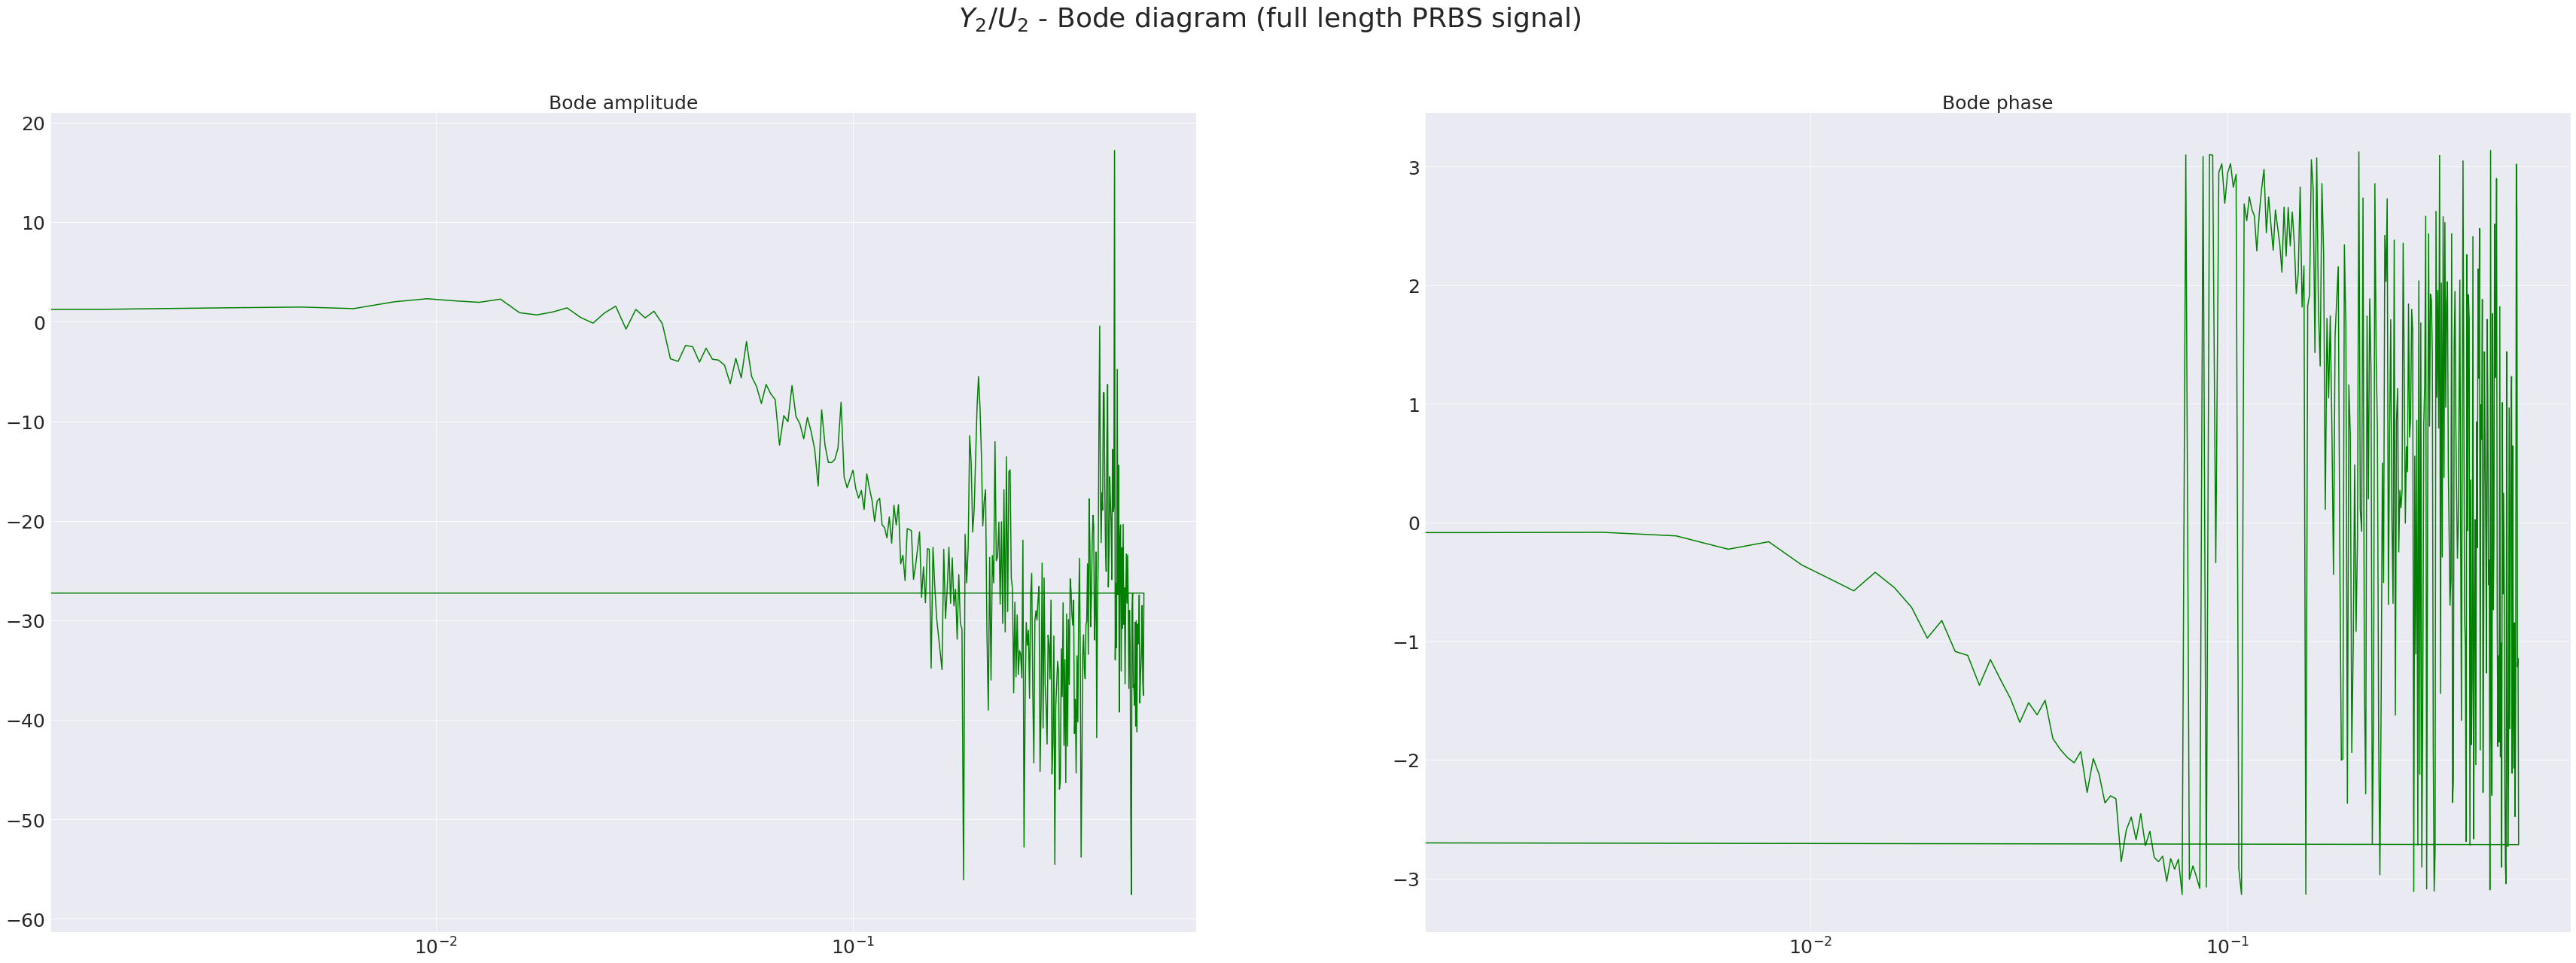

In [53]:
freqs = np.fft.fftfreq(len(u_train), 1)
ft_u = np.fft.fft(u_train)
ft_y = np.fft.fft(y_train)

fig, axn = plt.subplots(1,2,figsize=(60,20))
fig.suptitle(r'$Y_2/U_2$ - Bode diagram (full length PRBS signal)')
ft_G = ft_y / ft_u
axn[0].semilogx(freqs, 20 * np.log10(np.abs(ft_G)), c='g')
axn[1].semilogx(freqs, np.angle(ft_G), c='g')
axn[0].set_title('Bode amplitude')
axn[1].set_title('Bode phase')
axn[0].grid(True)
axn[1].grid(True)
plt.show()

### Should I use some prefiltering of $u$ and $y$, perhaps with Butterworth?